Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cuda:0
Running on GPU
Data prepared


  0%|          | 0/30 [00:00<?, ?it/s]

Network Architecture
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
)
Validation size:  227
Number of training samples:  2045
Number of test samples:  227
Model name:  model-1588588541
Show figure


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  0 Loss:  0.067


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  1 Loss:  0.067


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  2 Loss:  0.133


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  3 Loss:  0.2


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  4 Loss:  0.067


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  5 Loss:  0.0


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  6 Loss:  0.267


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  7 Loss:  0.133


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  8 Loss:  0.2


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch:  9 Loss:  0.067
begin the test


100%|██████████| 227/227 [00:01<00:00, 143.49it/s]


Accuracy:  0.96


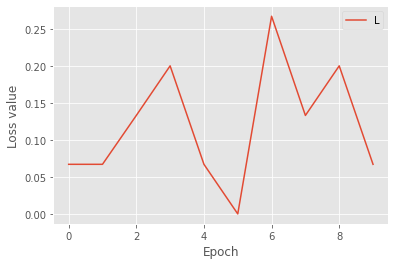

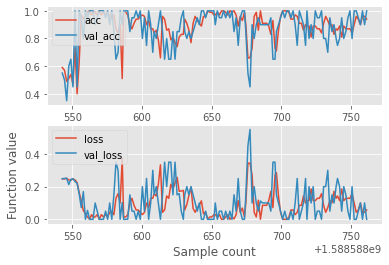

DONE


In [1]:
# USE THIS FOR FINAL OUTPUT
from google.colab import drive # layout for google drive

drive.mount('/content/drive') # mounting point for google drive


import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import time


# Use GPU
torch.cuda.is_available()
device = torch.device("cuda:0")

print(device)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")


# Loading data from google drive
training_data = np.load("/content/drive/My Drive/Yura/balanced_current.npy", allow_pickle=True)
print("Data prepared")

IMG_SIZE = 400
BATCH_SIZE = 70 # Was 80
EPOCHS = 10 # Was 8


X = torch.Tensor([i[0] for i in training_data]).view(-1, 1, IMG_SIZE, IMG_SIZE)
X = X / 255.0
y = torch.Tensor([i[1] for i in training_data])


# Define neural network architecture 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        global IMG_SIZE
        self.conv1 = nn.Conv2d(1, 32, 5) # 4-dimentions! (1, 32, 5, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 128, 5)
        self.conv5 = nn.Conv2d(128, 128, 5)
        self.conv6 = nn.Conv2d(128, 128, 5)
        
        x = torch.randn(IMG_SIZE, IMG_SIZE).view(-1, 1, IMG_SIZE, IMG_SIZE)
        
        self._to_linear = None
        self.convs(x)        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv5(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv6(x)), (2, 2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        return F.softmax(x, dim=1)
    
net = Net().to(device)

print("Network Architecture")
print(net)

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)

print("Validation size: ", val_size)

# Define number of training and test samples
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("Number of training samples: ", len(train_X))
print("Number of test samples: ", len(test_X))


MODEL_NAME = f"model-{int(time.time())}"

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print("Model name: ", MODEL_NAME)


def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    
    return acc, loss


def new_train():
    global IMG_SIZE, BATCH_SIZE, EPOCHS
    losses = []

    with open("/content/drive/My Drive/Yura/model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i: i + BATCH_SIZE].view(-1, 1, IMG_SIZE, IMG_SIZE).to(device)
                batch_y = train_y[i: i + BATCH_SIZE].to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                if i % 20 == 0: # Every N steps calculate accuracy, validation loss
                    val_acc, val_loss = new_test(size=20)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
                
            print("Epoch: ", epoch, "Loss: ", round(float(loss), 3))
            losses.append(round(float(loss), 3))

    plt.plot(losses)
    plt.legend("Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")

                    

# Accuracy test
def test(net):
    global IMG_SIZE
    print("begin the test")
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, IMG_SIZE, IMG_SIZE).to(device))[0]

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct / total, 3))
    

def new_test(size=50): # Was 32
    global IMG_SIZE
    random_start = np.random.randint(len(test_X) - size)
    #X, y = test_X[:size], test_y[:size]
    X, y = test_X[random_start: random_start + size], test_y[random_start: random_start + size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1, 1, IMG_SIZE, IMG_SIZE).to(device), y.to(device))

    return val_acc, val_loss


style.use("ggplot")

model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
    contents = open("/content/drive/My Drive/Yura/model.log", "r").read().split("\n")
    
    times = []
    accuracies = []
    losses = []
    
    val_accs = []
    val_losses = []
    
    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
            
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
            
    fig = plt.figure()
    
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)
    
    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)

    plt.xlabel("Sample count")
    plt.ylabel("Function value")
    plt.show()

print("Show figure")


new_train()
new_test()
test(net)
create_acc_loss_graph(model_name)

print("DONE")